In [2]:
import numpy as np
import osqp
import matplotlib.pyplot as plt
from scipy import sparse
import control as ct
from casadi import *
import dpilqr
import itertools
import cvxpy as cp

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from solvers.util import (
    compute_pairwise_distance,
    compute_pairwise_distance_nd_Sym,
    define_inter_graph_threshold,
    distance_to_goal,
    split_graph, 
    generate_f,
    generate_f_human_drone,
    objective,
    generate_min_max_input,
    generate_min_max_state
)

In [5]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = np.zeros((6*n_agent, 6*n_agent))
    B_tot = np.zeros((6*n_agent, 3*n_agent))
    A = np.array([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = np.array([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot

In [6]:
from solvers import util
from multiprocessing import Process, Pipe
import cvxpy as cp

In [7]:
def compute_pairwise_distance_CVX(X, x_dims, n_dims):
    """Analog to the above whenever some agents only use distance in the x-y plane"""
    CYLiER_RADIUS = 0.2

    n_states = x_dims[0]
    n_agents = len(x_dims)
    distances = []
    eps = 1e-3

    for i, n_dim_i in zip(range(n_agents), n_dims):
        for j, n_dim_j in zip(range(i + 1, n_agents), n_dims[i + 1 :]):
            n_dim = min(n_dim_i, n_dim_j)

            Xi = X[i * n_states : i * n_states + n_dim]
            Xj = X[j * n_states : j * n_states + n_dim]
            dX = Xi-Xj

            if n_dim == 3:
                # distances.append(cp.sqrt(dX[0]**2+dX[1]**2+dX[2]**2))
                distances.append(cp.norm(dX))
            else:
                distances.append(cp.sqrt(dX[0]**2+dX[1]**2 + eps)+CYLiER_RADIUS)
    
    return distances

#### Using IPOPT for local constraint problems (using Casadi pcakage):

In [8]:
from casadi import *
import casadi as cs

In [52]:
"""Define constants"""
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 5
Q = np.diag([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*np.eye(N*n_inputs)
radius = 0.35
Ad, Bd = linear_kinodynamics(0.1, N)


f_list = {}
d = {} 
states = {}
for id in range(N):
    d["opti_{0}".format(id)] = Opti()
    
    #Augmented state : Y = (x(0),x(1),...,x(N),u(0),...,u(N-1))
    
    states["Y_{0}".format(id)] = d[f"opti_{id}"].variable((T+1)*nx + T* nu)
    cost = 0
  
    #Quadratic tracking cost
      
    for t in range(T):
        cost += (states["Y_{0}".format(id)][:(T+1)*nx][t*nx:(t+1)*nx]-xr).T @ Q @ (states["Y_{0}".format(id)][:(T+1)*nx][t*nx:(t+1)*nx]-xr) +\
                (states["Y_{0}".format(id)][(T+1)*nx:][t*nu:(t+1)*nu]).T @ R @ (states["Y_{0}".format(id)][(T+1)*nx:][t*nu:(t+1)*nu])
    
    cost += (states["Y_{0}".format(id)][:(T+1)*nx][T*nx:(T+1)*nx] - xr).T @ Qf @ (states["Y_{0}".format(id)][:(T+1)*nx][T*nx:(T+1)*nx] - xr)

    # f_list.append(cost)
    f_list["cost_{0}".format(id)] = cost

def run_worker(agent_id, cost, pipe):
    n_states = 6
    xbar = d[f"opti_{agent_id}"].parameter((T+1)*nx + T*nu)
    d[f"opti_{agent_id}"].set_value(xbar, cs.GenDM_zeros((T+1)*nx + T*nu,1))    
    
    u = d[f"opti_{agent_id}"].parameter((T+1)*nx + T*nu)
    d[f"opti_{agent_id}"].set_value(u, cs.GenDM_zeros((T+1)*nx + T*nu,1))
    
    #This is the scaled Lagrange multiplier

    rho = 5
    cost += (rho/2)*sumsqr(states[f"Y_{agent_id}"] - xbar + u)
    
    # ADMM loop
    # X_full = np.zeros((0,nx))
    # X_full = np.r_[X_full,x0.reshape(1,-1)]
    # U_full = np.zeros((0,nu))
    
    iter = 0
    while True:
        try:
            x_dims = [n_states]*n_agents
            f = util.generate_f(x_dims)
            # f is the concatenated dynamics of all agents
            dt = 0.1
            for k in range(T): #Dynamics constraint
                # Runge-Kutta 4 integration
                k1 = f(states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx], states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu])
                k2 = f(states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx]+dt/2*k1, states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu])
                k3 = f(states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx]+dt/2*k2, states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu])
                k4 = f(states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx]+dt*k3,   states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu])
                x_next = states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx] + dt/6*(k1+2*k2+2*k3+k4) 

                d[f"opti_{agent_id}"].subject_to(states[f"Y_{agent_id}"][:(T+1)*nx][(k+1)*nx:(k+2)*nx]==x_next) # close the gaps
                
                #Actuator constraints
                d[f"opti_{agent_id}"].subject_to(states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu] <= np.tile(np.array([3, 3, 3]),(N,)).reshape(-1,1))
                d[f"opti_{agent_id}"].subject_to(np.tile(np.array([-3, -3, -3]),(N,)).reshape(-1,1) <= states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu])
            
            d[f"opti_{agent_id}"].subject_to(states[f"Y_{agent_id}"][0:nx] == x0) #Initial condition constraint
            
            for k in range(T+1):
                #Pair-wise Euclidean distance between each pair of agents
                distances = util.compute_pairwise_distance_nd_Sym(states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx],[6,6,6], [3,3,3])
                #Collision avoidance cost
                for dist in distances:
                    cost -= (dist - radius)**2
                    
            d[f"opti_{agent_id}"].minimize(cost)
            
            d[f"opti_{agent_id}"].solver("ipopt")
            sol = d[f"opti_{agent_id}"].solve()
            
            pipe.send(sol.value(states[f"Y_{agent_id}"]))
            print(f'parameter u has value {sol.value(u)}')
            
            d[f"opti_{agent_id}"].set_value(xbar, pipe.recv()) #receive the averaged result from the main process.
            d[f"opti_{agent_id}"].set_value(u, sol.value( u + states[f"Y_{agent_id}"] - xbar))

            iter += 1
            print(f'Current iteration is {iter}')
            
        except EOFError:
            print("Connection closed.")
            break
                
    

pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_worker, args=(i, f_list[f"cost_{i}"], remote))]
    procs[-1].start()

MAX_ITER = 30
solution_list = []
iter = 0
for i in range(MAX_ITER):
    # Gather and average xi

    xbar = sum(pipe.recv() for pipe in pipes)/N
    # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

    solution_list.append(xbar)
    # print(f'average of xbar is {np.mean(xbar)}\n')

    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)
        
    if np.all(distance_to_goal(solution_list[-1][:(T+1)*nx].reshape((T+1,nx))[-1], xr.flatten(), 3, 6) < 0.1):
        break
    
    iter += 1

[p.terminate() for p in procs]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimizat

CasADi - 2023-06-22 10:CasADi - CasADi - 2023202334--:060623-- WARNING("2222NLP is overconstrained: There are 216 equality constraints but only 153 variables.  ") [1010.../casadi/core/nlpsol.cpp:630::]
3434::

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.



2323

Number of nonzeros in equality constraint Jacobian...:      666


 WARNING(" WARNING("

Number of nonzeros in inequality constraint Jacobian.:      180


NLP is overconstrained: There are 216 equality constraints but only 153 variables.NLP is overconstrained: There are 216 equality constraints but only 153 variables.

Number of nonzeros in Lagrangian Hessian.............:     1251



") [") [.../casadi/core/nlpsol.cpp:630.../casadi/core/nlpsol.cpp:630]
]


Exception of type: TOO_FEW_DOF in file "/work/build/external_projects/src/ipopt-external/src/Interfaces/IpIpoptApplication.cpp" at line 655:
 Exception message: status != TOO_FEW_DEGREES_OF_FREEDOM evaluated false: Too few degrees of freedom (rethrown)!
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.


EXIT: Problem has too few degrees of freedom.
Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:      180
Number of nonzeros in inequality constraint Jacobian.:      180
      solver Number of nonzeros in Lagrangian Hessian.............:     1251

Number of nonzeros in Lagrangian Hessian.............:     1251

 :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_grad_f Exception of type: TOO_FEW_DOF in file "/work/build/external_projects/src/ipopt-external/s

Process Process-26:


       total        total  |        0 (       0)  37.39ms ( 37.39ms)         1
 |        0 (       0)  37.28ms ( 37.28ms)         1


Process Process-25:
Process Process-27:
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/tmp/ipykernel_319/3276497477.py", line 104, in run_worker
    sol = d[f"opti_{agent_id}"].solve()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/randychen233/ana

EOFError: 

#### Using QP solver for local constrained problems (not really working)

In [10]:
# class AdmmMPC:
#     def __init__(self, nx, nu, x0, xr, T, Q, R, Qf, N, Ad, Bd, radius = 0.3, MAX_ITER=10):
#         nx = nx #Total No. of states
#         nu = nu #Total No. of inputs
#         xr = xr #Final cond.
#         x0 = x0 #Initial cond.
#         N = N #No. of agents
#         T = T #Horizon
#         # y_state = cp.Variable((((T+1)*nx + T * nu, 1)))
#         Q = Q #Positive definite
#         R = R #Positive definite ..
#         Qf = Qf #Positive definite
#         radius = radius #Collision threshold radius
#         Ad = Ad #State matrix
#         Bd = Bd #Input matrix
#         MAX_ITER = MAX_ITER

"""Define constants"""
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 5
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*sparse.eye(N*n_inputs)
radius = 0.3
Ad, Bd = linear_kinodynamics(0.1, N)

cost = 0
# x_trj_var = cp.reshape(y_state[0:(T+1)*nx],[T+1, nx])
# u_trj_var = cp.reshape(y_state[(T+1)*nx:], [T, nu])
f_list = []
for id in range(N):
    y_state = cp.Variable((((T+1)*nx + T * nu, 1)))
    cost = 0
    for t in range(T):
        #Quadratic tracking cost
        # cost += cp.quad_form(cp.reshape(y_state[:(T+1)*nx],[T+1, nx])[t,:]-xr.flatten(),Q) + \
        # cp.quad_form(cp.reshape(y_state[(T+1)*nx:], [T, nu])[t,:],R)
        cost += cp.quad_form(y_state[:(T+1)*nx][t*nx:(t+1)*nx]-xr, Q) + \
        cp.quad_form(y_state[(T+1)*nx:][t*nu:(t+1)*nu], R)
    cost += cp.quad_form(y_state[:(T+1)*nx][T*nx:(T+1)*nx]-xr, Qf)  
    f_list.append(cost)


def run_worker(f, pipe):
    n_states = 6
    xbar = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu))
    u = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu)) 
    #This is the scaled Lagrange multiplier

    rho = 5
    f += (rho/2)*cp.sum_squares(y_state.flatten() - xbar + u)
    
    # ADMM loop
    # X_full = np.zeros((0,nx))
    # X_full = np.r_[X_full,x0.reshape(1,-1)]
    # U_full = np.zeros((0,nu))
    
    iter = 0
    while True:
        try:
            coll_cost = 0
            constr = []
            constr += [y_state[0:nx] == x0]
            for k in range(T):
                constr += [y_state[:(T+1)*nx][(k+1)*nx:(k+2)*nx] \
                            == Ad @ y_state[:(T+1)*nx][k*nx:(k+1)*nx] \
                                + Bd @ y_state[(T+1)*nx:][k*nu:(k+1)*nu]]  
                    
                constr += [y_state[(T+1)*nx:][k*nu:(k+1)*nu]<= np.tile(np.array([3, 3, 3]),(N,)).reshape(-1,1)]
                constr += [np.tile(np.array([-3, -3, -3]),(N,)).reshape(-1,1) <= y_state[(T+1)*nu:][k*nu:(k+1)*nu]]
                distances = compute_pairwise_distance_CVX(y_state[:(T+1)*nx][k*nx:(k+1)*nx],[6,6,6], [3,3,3])
                #Collision avoidance cost
                
                for dist in distances:
                    # coll_cost += cp.square(cp.maximum(0, dist - radius))*100
                    sigmoid_term = cp.exp(5*(dist - radius))
                    coll_cost += sigmoid_term
                #Solve local constrained problem with OSQP solver in CVXPY
                # if iter > 0 :
                #     pos_prev = state_prev[k]
                #     # pos_prev = X_full[iter-1]
                #     # pos_curr = cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[k]
                #     for i in range(N):
                #         for j in range(N):
                #             if j != i:
                #                 #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                #                 # A sequential convex programming approach" for the linearization step;
                #                 constr += [cp.norm(pos_prev[j*n_states:j*n_states+3]-  \
                #                 pos_prev[i*n_states:i*n_states+3]) + \
                #                 (pos_prev[j*n_states:j*n_states+3].T- \
                #                     pos_prev[i*n_states:i*n_states+3].T)/cp.norm(pos_prev[j*n_states:j*n_states+3] \
                #                 -pos_prev[i*n_states:i*n_states+3])@  \
                #                 ((y_state[:(T+1)*nx][k*nx:(k+1)*nx][j*n_states:j*n_states+3] \
                #                 -y_state[:(T+1)*nx][k*nx:(k+1)*nx][i*n_states:i*n_states+3])- \
                #                 (pos_prev[j*n_states:j*n_states+3]- \
                #                     pos_prev[i*n_states:i*n_states+3]).reshape(1,-1)) >= radius]

            coll_cost = coll_cost / n_agents
            prox = cp.Problem(cp.Minimize(f + coll_cost),constr)
            prox.solve(verbose=True)
            pipe.send(y_state.value.flatten())
            xbar.value = pipe.recv() #receive the averaged result from the main process.
            u.value += y_state.value.flatten() - xbar.value

            # ctrl = xbar.value[(T+1)*nx:].reshape((T,nu))[1]
            # xi = Ad @ xi + Bd @ ctrl
            # X_full = np.r_[X_full,xi]
            # U_full = np.r_[U_full, ctrl.reshape(1,-1)]
                    
            # state_prev = xbar.value[:(T+1)*nx].reshape((T+1, nx))
            iter += 1
            print(f'Current iteration is {iter}')
            
        except EOFError:
            print("Connection closed.")
            break
                
    

pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_worker, args=(f_list[i], remote))]
    procs[-1].start()

MAX_ITER = 30
solution_list = []
iter = 0
for i in range(MAX_ITER):
    # Gather and average xi

    xbar = sum(pipe.recv() for pipe in pipes)/N
    # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

    solution_list.append(xbar)
    # print(f'average of xbar is {np.mean(xbar)}\n')

    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)
        
    if np.all(distance_to_goal(solution_list[-1][:(T+1)*nx].reshape((T+1,nx))[-1], xr.flatten(), 3, 6) < 0.1):
        break
    
    iter += 1

[p.terminate() for p in procs]
    


                                     CVXPY                                     
                                     v1.3.1                                    
                                     CVXPY                                     
                                     v1.3.1                                    

(CVXPY) Jun 20 09:56:55 PM: Your problem has 306 variables, 16 constraints, and 306 parameters.
(CVXPY) Jun 20 09:56:55 PM: Your problem has 306 variables, 16 constraints, and 306 parameters.
(CVXPY) Jun 20 09:56:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 20 09:56:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
                                     CVXPY                                     
                                     v1.3.1                                    
===============================================================================(CVXPY) Jun 20 09:56:55 PM: It is co

/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jun 20 09:56:56 PM: Problem status: optimal_inaccurate
(CVXPY) Jun 20 09:56:56 PM: Optimal value: 1.717e+04
(CVXPY) Jun 20 09:56:56 PM: Compilation took 1.749e-01 seconds
(CVXPY) Jun 20 09:56:56 PM: Solver (including time spent in interface) took 1.644e-02 seconds
Current iteration is 1Current iteration is 1Current iteration is 1


                                     CVXPY                                     
                                     v1.3.1                                    
                                     CVXPY                                     
                                     v1.3.1                                    
                                     CVXPY                                     
                  

Process Process-5:


(CVXPY) Jun 20 09:56:56 PM: Invoking solver ECOS  to obtain a solution.


Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_26108/3958744664.py", line 106, in run_worker
    prox.solve(verbose=True)
Process Process-4:
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 493, in solve
    return solve_func(self, *args, **kwargs)
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 1068, in _solve
    self.unpack_results(solution, solving_chain, inverse_data)
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------

  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 493, in solve
    return solve_func(self, *args, **kwargs)


  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 1068, in _solve
    self.unpack_results(solution, solving_chain, inverse_data)


(CVXPY) Jun 20 09:56:56 PM: Problem status: optimal_inaccurate


  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 1393, in unpack_results
    raise error.SolverError(


(CVXPY) Jun 20 09:56:56 PM: Optimal value: 1.600e+04


cvxpy.error.SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


(CVXPY) Jun 20 09:56:56 PM: Compilation took 1.386e-01 seconds
(CVXPY) Jun 20 09:56:56 PM: Solver (including time spent in interface) took 1.875e-02 seconds

ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.313e+02  +2e+02  1e+00  1e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -1.318e+03  -1.645e+03  +3e+01  5e-01  1e+00  5e+00  2e-01  0.8262  2e-02   1  1  1 |  0  0
 2  -1.137e+04  -1.167e+04  +5e+00  5e-01  1e+00  3e+01  3e-02  0.9253  9e-02   2  2  2 |  0  0
 3  -1.224e+04  -1.254e+04  +4e+00  5e-01  1e+00  4e+01  3e-02  0.2149  6e-01   1  1  1 |  0  0
 4  -2.203e+04  -2.228e+04  +2e+00  5e-01  1e+00  7e+01  1e-02  0.6083  2e-01   1  1  1 |  0  0
 5  -1.074e+04  -1.095e+04  +2e+00  5e-01  8e-01  7e+01  1e-02  0.4676  4e-01   1  1  1 |  0  0
 6  -8.506e+03  -8.634e+03  +8e-01  4e-01  6e-01  8e+01  5e-03  0.5501  3e-02   

EOFError: 

In [507]:
len(solution_list)

10

In [508]:
x_trj_converged = solution_list[-1][:(T+1)*nx].reshape((T+1,nx))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


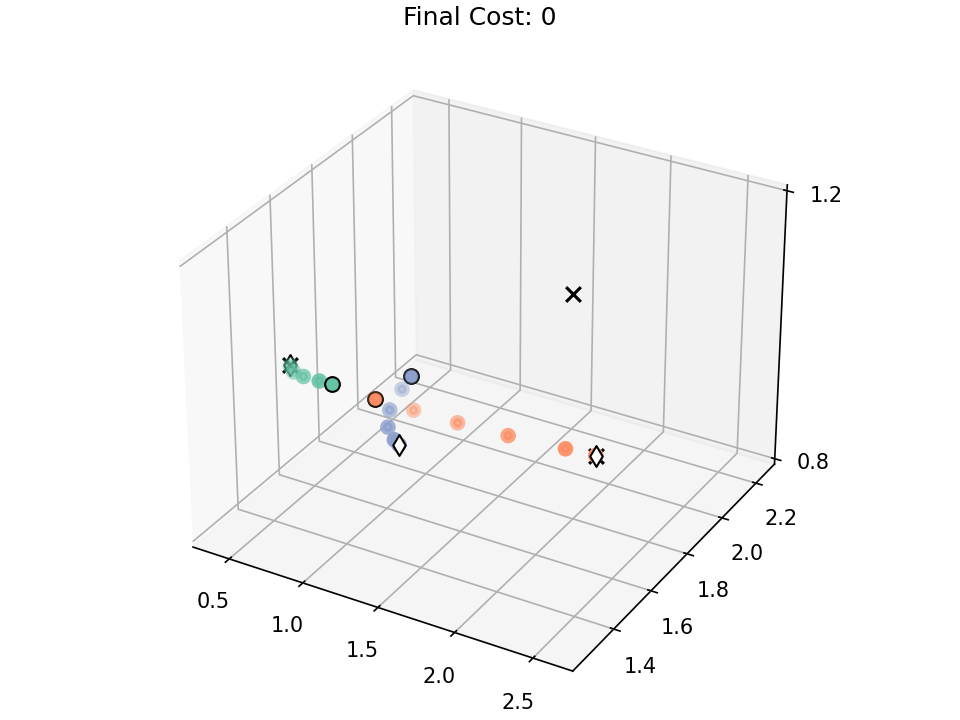

In [509]:
plt.figure(dpi=150)
dpilqr.plot_solve(x_trj_converged, 0, xr, [6,6,6], True, 3)
plt.gca().set_zticks([0.8,1.2], minor=False)

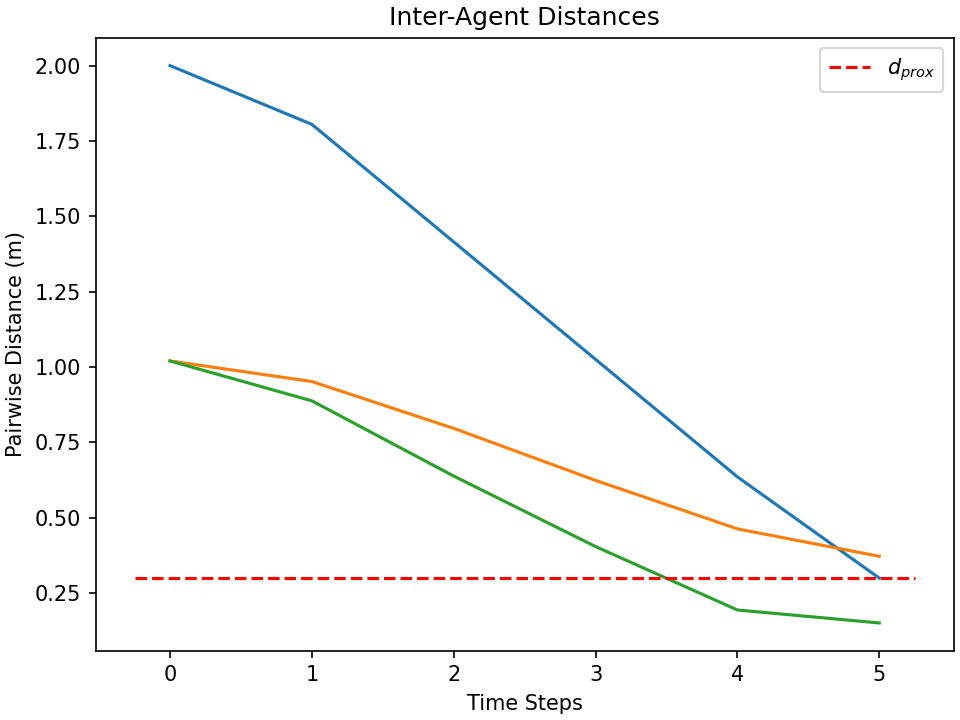

In [510]:
plt.figure(dpi=150)
dpilqr.plot_pairwise_distances(x_trj_converged,[6,6,6],[3,3,3],0.3)

### ADMM with only consensus constraints (toy example)

In [145]:
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 15
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*sparse.eye(N*n_inputs)



# x_trj_var = cp.reshape(y_state[0:(T+1)*nx],[T+1, nx])
# u_trj_var = cp.reshape(y_state[(T+1)*nx:], [T, nu])
f_list = []
for id in range(N):
    y_state = cp.Variable((((T+1)*nx + T * nu, 1)))
    cost = 0
    for t in range(T):
        #Quadratic tracking cost
        # cost += cp.quad_form(cp.reshape(y_state[:(T+1)*nx],[T+1, nx])[t,:]-xr.flatten(),Q) + \
        # cp.quad_form(cp.reshape(y_state[(T+1)*nx:], [T, nu])[t,:],R)
        cost += cp.quad_form(y_state[:(T+1)*nx][t*nx:(t+1)*nx]-xr, Q) + \
        cp.quad_form(y_state[(T+1)*nx:][t*nu:(t+1)*nu], R)
    cost += cp.quad_form(y_state[:(T+1)*nx][T*nx:(T+1)*nx]-xr, Qf)  
    f_list.append(cost)


def run_worker(f, pipe):

    xbar = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu))
    u = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu)) 
    #This is the scaled Lagrange multiplier

    rho = 1
    f += (rho/2)*cp.sum_squares(y_state.flatten() - xbar + u)
    
    # ADMM loop
    
    iter = 0
    prox = cp.Problem(cp.Minimize(f))
    while True:
        try:
            prox.solve(verbose=True)
            print(f'updated augmented state has value {y_state.value.flatten()}')
            pipe.send(y_state.value.flatten())
            xbar.value = pipe.recv() #receive the averaged result from the main process.
            u.value += y_state.value.flatten() - xbar.value

            iter += 1
            print(f'Current iteration is {iter}')
        except EOFError:
            print("Connection closed.")
            break
                
    

pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_worker, args=(f_list[i], remote))]
    procs[-1].start()

MAX_ITER = 30
solution_list = []
for i in range(MAX_ITER):
    # Gather and average xi

    xbar = sum(pipe.recv() for pipe in pipes)/N
    # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

    solution_list.append(xbar)
    # print(f'average of xbar is {np.mean(xbar)}\n')

    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)

[p.terminate() for p in procs]

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 20 10:45:13 AM: Your problem has 846 variables, 0 constraints, and 846 parameters.
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 20 10:45:13 AM: Your problem has 846 variables, 0 constraints, and 846 parameters.
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 20 10:45:13 AM: Your problem has 423 variables, 0 constraints, and 846 parameters.
(CVXPY) Jun 20 10:45:13 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 20 10:45:13 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-----------------------

[None, None, None]

In [148]:
len(solution_list)

30

In [149]:
xr.T

array([[2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
        2.2, 1. , 0. , 0. , 0. ]])

In [150]:
solution_list[-1][:(T+1)*nx].reshape((T+1, nx)) #It works!

array([[2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],

In [152]:
solution_list[-1][:(T+1)*nx].reshape((T+1, nx))[0] #It works!

array([2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
       2.2, 1. , 0. , 0. , 0. ])

In [153]:
xr.T

array([[2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
        2.2, 1. , 0. , 0. , 0. ]])